Device = cpu
Mean field fixed pt: tensor([0.0510, 0.4310], dtype=torch.float64)
e-vals of MFJac [-1.19194174+5.13034028j -1.19194174-5.13034028j]
Mean and std of EE entries: tensor(0.0347) tensor(0.0355)
Time to generate connectivity: 0.0009911060333251953 s
Time for svdW calc: 0.00461888313293457 s
100
Time for first sim: 0.26760411262512207 s
Time to generate x(t): 0.006499052047729492 s
Time for second sim: 1.2371571063995361 s
done


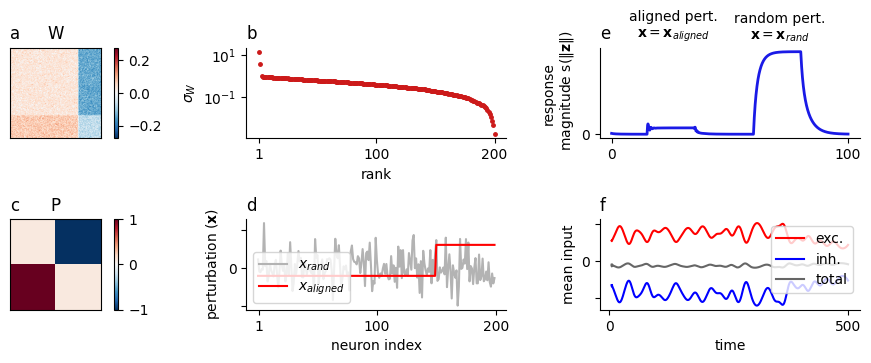

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA


# Save figures?
SaveFigs=True


# Choose a device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device='cpu'
print('Device =',device)

torch.manual_seed(0)

# Number of neurons in recurrent net
N = 200

# Duration of simulation in ms
T = 100
dt = 0.01


# Number of excitatory, inhibitory, and external neurons
Ne = int(N*.75)
Ni = N-Ne

# Connection weights
jee = .5/np.sqrt(N)
jei = -2/np.sqrt(N)
jie = 1.0/np.sqrt(N)
jii = -1.0/np.sqrt(N)



# Mean external input scaling
xe0 = 0.2*np.sqrt(N)
xi0 = 0.1*np.sqrt(N)

# Mean field
WMF=torch.tensor([[jee*Ne,jei*Ni],[jie*Ne,jii*Ni]])
XMF=torch.tensor([xe0,xi0], dtype=torch.double)
rMF=torch.linalg.inv(torch.eye(2)-WMF)@XMF
print('Mean field fixed pt:',rMF)
# Synaptic timescales
taue = 2
taui = 1
JacMF=torch.tensor([[(jee*Ne-1)/taue, jei*Ni/taue],[jie*Ne/taui, (jii*Ni-1)/taui]])
lamMF=np.linalg.eigvals(JacMF)
print('e-vals of MFJac',lamMF)


# # Array of synaptic timescales
tausyn = torch.zeros(N).to(device)
tausyn[:Ne] = taue
tausyn[Ne:] = taui
eta = dt/tausyn

# Spectral radius of random part
rho = 0.5

with torch.no_grad():

    # Get synaptic connectivity matrix
    t0=tm()
    W0 = torch.zeros(N,N).to(device)
    W0[:Ne,:Ne] = jee
    W0[:Ne,Ne:] = jei
    W0[Ne:,:Ne] = jie
    W0[Ne:,Ne:] = jii
    W1 = rho*torch.randn(N,N).to(device)/np.sqrt(N)
    W = W0 + W1
    print('Mean and std of EE entries:',W[:Ne,:Ne].mean(),W[:Ne,:Ne].std())
    tJ = tm()-t0
    print('Time to generate connectivity:',tJ,'s')
    


    # Build model
    model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)


    t0=tm()
    #sigmaW = ToNP(torch.linalg.svdvals(W.cpu()))
    UW,sigmaW,VWT = torch.linalg.svd(W.cpu())
    UW0,sigmaW0,VW0T = torch.linalg.svd(W0.cpu())
    VW0=VW0T.T
    #sigmaW = ToNP(sigmaW)
    PW0 = (UW0.T@VW0T.T)[:2,:2]
    tsvdW = tm()-t0
    print('Time for svdW calc:',tsvdW,'s')


####### First simulation
with torch.no_grad():

    x0 = torch.zeros(N).to(device)
    x0[:Ne] = 0*xe0
    x0[Ne:] = 0*xi0

    u = UW0[:,0].to(device)
    v = VW0[:,0].to(device)
    if u.mean()<0:
        u=-u
    
    urand = torch.randn(N).to(device)
    urand = urand/urand.norm()

    # Strength of stimuli
    cx=10

    # Duration of stimuli in time
    tstim = 20

    # Duration of breaks between stimuli
    tbreak = 25

    # Times at which the two stimuli turn on and off
    t1on = 15
    t1off = t1on+tstim
    t2on = t1off+tbreak
    t2off = t2on+tstim

    # Duration of sim
    T = t2off+20
    print(T)
    time=np.arange(0,T,dt)
    Nt=len(time)

    # Build input
    x = x0+torch.zeros(1, Nt, N).to(device)
    x[0,int(t1on/dt):int(t1off/dt),:] += cx*u
    x[0,int(t2on/dt):int(t2off/dt),:] += cx*urand

    # Run simulation
    t0=tm()
    with torch.no_grad():
        r = model(x, return_time_series = True, store_hidden_history = True, initial_state=(.1/np.sqrt(N))*torch.randn(N).to(device) )
        z = model.hidden_state_history
        tSim1=tm()-t0
        print('Time for first sim:',tSim1,'s')


# Duration of sim
T3=500

# Timescale and strength of Guassian random stimulus
taux=10
sigmax=.25

# Discretized time for second sim
time3=np.arange(0,T3,dt)
Nt3=len(time3)

# Generate input and run sim
with torch.no_grad():
    t0=tm()
    temp = 1+sigmax*MakeSmoothGaussianProcess(taux,Nt3,dt,1,device=device).T
    x3 = torch.zeros(1,Nt3,N)
    x3[0,:,:] = temp
    #x3 = sigmax*MakeSmoothGaussianProcess(taux,Nt3,dt,N,device=device).T
    #x3 = x3[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')
    t0=tm()
    r3 = model(x3, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z3 = model.hidden_state_history


    tsim3 = tm()-t0
    print('Time for second sim:',tsim3,'s')


    # Get input variable
    y3=model.recurrent_layer(r3)


    def PosPart(x):
        return x*(x>0)
    def NegPart(x):
        return x*(x<0)
    Ie = PosPart(y3+x3)
    Ii = NegPart(y3+x3)




### Make Figure 1
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N


fig, axes = plt.subplot_mosaic("abe;cdf",figsize=(10,3.75))



c0='a'
ax0 = axes[c0]
im = ax0.imshow(ToNP(W), cmap='RdBu_r', vmin=-W.abs().max(), vmax=W.abs().max())
cbar = fig.colorbar(im, ax=ax0)
cbar.set_ticks([-0.2,0,0.2])
#cax = fig.add_axes([ax0.get_position().x1,ax0.get_position().y0,0.02,ax0.get_position().height])
#plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
#cbar = fig.colorbar(im, cax = cax)
#cbar.set_ticks([-1,0,1])
ax0.set_title('W')
ax0.set_xticks([])
ax0.set_yticks([])
#ax0.set_ylabel('W')
ax0.set_title(c0,loc='left')

c0='b'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,ToNP(sigmaW),'.',markersize=5, color=Wclr)
#ax0.set_ylim([0,1.1])
ax0.set_xlim([-10,N+10])
#ax0.set_yticks([0,.5,1])
ax0.set_xticks([1,int(N/2),N])
ax0.set_xlabel('rank')
ax0.set_ylabel(r'$\sigma_W$')
ax0.set_yscale('log')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


c0='c'
ax0 = axes[c0]
im = ax0.imshow(ToNP(PW0), cmap='RdBu_r', vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=ax0)
cbar.set_ticks([-1,0,1])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('P')
ax0.set_title(c0,loc='left')



c0='d'
ax0 = axes[c0]
ax0.plot(urand,color=[.7,.7,.7],label=r'$x_{rand}$')
ax0.plot(v,color='r',label=r'$x_{aligned}$')
ax0.set_xlabel('neuron index')
ax0.set_ylabel(r'perturbation ($\bf x$)')
ax0.set_xticks([1, 100, 200])
ax0.set_yticks([-.2,0,.2])
ax0.set_yticklabels(['','0',''])
ax0.legend(loc='lower left')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)


c0='e'
ax0 = axes[c0]
xmin, xmax = ax0.get_xaxis().get_view_interval()
ymin, ymax = ax0.get_yaxis().get_view_interval()
def normalize(x):
    return (x-x.min())/(x.max()-x.min())
ax0.plot(time,ToNP((z[0,:,:].norm(dim=1))), color=zclr, lw=2)
ax0.set_ylabel('response\n magnitude s'+r'($\|\mathbf{z}\|$)')
#ax0.set_xlabel('time')
ax0.set_yticks([0])
ax0.set_xticks([0,T])
#ax0.text(0,.5,r'$\|\mathbf{z}\|$'+'\n',rotation='vertical',horizontalalignment='right')
ax0.text((t1on+t1off+tstim/8)/2,(z[0,:,:].norm(dim=1)).max()*1.1,'aligned pert.\n'+r'$\mathbf{x}=\mathbf{x}_{aligned}$',horizontalalignment='center',verticalalignment='bottom')
ax0.text((t2on+t2off+tstim/8)/2,(z[0,:,:].norm(dim=1)).max()*1.1,'random pert.\n'+r'$\mathbf{x}=\mathbf{x}_{rand}$',horizontalalignment='center',verticalalignment='bottom')
#ax0.axis('off')
sns.despine(ax=ax0)
ax0.set_title(c0,loc='left')



c0='f'
ax0 = axes[c0]
tmax=500
Iplot=range(int(5/dt),int(tmax/dt))
ax0.plot(time3[Iplot],ToNP(Ie[0,Iplot,:].mean(dim=1)),color='r',label='exc.')
ax0.plot(time3[Iplot],ToNP(Ii[0,Iplot,:].mean(dim=1)),color='b',label='inh.')
ax0.plot(time3[Iplot],ToNP((Ie[0,Iplot,:]+Ii[0,Iplot,:]).mean(dim=1)),color=[.4,.4,.4],label='total')
ax0.set_xlabel('time')
ax0.set_ylabel('mean input')
plt.legend(loc='upper right')#loc=(.6,.9))
ax0.set_xticks([0,tmax])
ax0.set_yticks([-.04,0,.04])
ax0.set_yticklabels(['','0',''])
sns.despine(ax=ax0)
ax0.set_title(c0,loc='left')



fig.tight_layout()


if SaveFigs:
    fig.savefig('./Figures/Figure4.pdf')
    fig.savefig('./Figures/Figure4unpolished.svg')
print('done')

